## TRACER 04 JUNE 2022

### RHI + LIGHTNING

[Lightning Data for June 4th](http://pogo.tosm.ttu.edu/data/TRACER/20220604-analysis/)

In [23]:
import matplotlib.pyplot as plt
import pyart
import numpy as np
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
from datetime import datetime, date, time, timedelta
import act
import pyart.graph.cm as pcm
import warnings
warnings.filterwarnings("ignore")

from lmatools.coordinateSystems import RadarCoordinateSystem, GeographicSystem, TangentPlaneCartesianSystem, MapProjection

### [LMAinterceptRHI](https://github.com/jcssouza/LMAinterceptRHI)

In [24]:
import sys
sys.path.append("./LMAinterceptRHI/")
# Adapted functions from LMAinterceptRHI
from radarlma2local import geo_to_tps
from ortho_proj import rot_mat_lma, close_sources, closest_pt_radarloc
from radar_processing import r_z_centers_edges_mesh
from interp_funcs import centers_to_edges_1d, coords_2d

### Radar

In [25]:
# Download radar file
import os
from dotenv import load_dotenv
load_dotenv('csapr.env')
username = os.getenv('USER_ACT')
token = os.getenv('TOKEN')

datastream = "houcsapr2cfrS2.a1"
startdate = "2022-06-04"
enddate   = "2022-06-04"
csapr_file = act.discovery.download_data(username,token, datastream, startdate, enddate,time='221116')

radar = pyart.io.read(csapr_file[0])
print('Radar scan type: ' + radar.scan_type)

# -- Get radar time
d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
radar_time = datetime.combine(d,t)
print(radar_time)

[DOWNLOADING] houcsapr2cfrS2.a1.20220604.221116.nc
Radar scan type: rhi
2022-06-04 22:11:16


In [26]:
# -- Radar scan processing
RZ_centers, RZ_edges = r_z_centers_edges_mesh(radar, 0)
r_c = RZ_centers[:,:,0]
z_c = RZ_centers[:,:,1]
r_e = RZ_edges[:,:,0]
z_e = RZ_edges[:,:,1]

# Radar shape
# -- To filter VHF sources out of the radar scan domain
# --- Create the polygon: all ranges, lowest and highest elevation
from shapely.geometry import Polygon, Point, MultiPoint
scan_poly = Polygon(np.append(np.append(RZ_edges[-1, :-1],RZ_edges[0, :-1], axis = 0), RZ_edges[:, - 1], axis = 0))
# scan_poly

### Lightning

In [27]:
# Read lma file
lightning_file = './LYLOUT_220604_190000_18000_map500m.nc'
lma_data = xr.open_dataset(lightning_file)
# lma_data.event_time.values = pd.to_datetime(lma_data.event_time.values.astype('M8[us]')).to_pydatetime()

In [28]:
# Filter time and altitude
seconds = 30
sources = (lma_data.event_altitude < 18e3) & (abs( (np.datetime64(radar_time) - lma_data.event_time)/ np.timedelta64(1, 's') ) < seconds) 
subset = lma_data[{'number_of_events': sources}]

flashes_ids = np.unique(subset.event_parent_flash_id).astype(int)
print(f'{len(flashes_ids)} flashes ids within {2*seconds} seconds.')

# Select events info for individual flash id ('number_of_events' dimension)
nid = 64
one_id = lma_data.event_parent_flash_id == flashes_ids[nid]
flash_events = lma_data[{'number_of_events': one_id}]

# Filter data (stations > 5, chi2 < 2)
filter_events = (flash_events.event_chi2 < 2) & (flash_events.event_stations > 5)
filter_events
filtered_flash = flash_events[{'number_of_events':filter_events}]

# Only one flash events info in the dataset
all_dims = dict(filtered_flash.dims)
all_dims.pop('number_of_events') #all dims will no longer have 'number of flashes’
one_flash = filtered_flash.drop_dims(all_dims.keys())
one_flash

135 flashes ids within 60 seconds.


<xarray.Dataset>
Dimensions:                              (number_of_events: 1652)
Coordinates:
    event_latitude                       (number_of_events) float32 ...
    event_longitude                      (number_of_events) float32 ...
    event_time                           (number_of_events) datetime64[ns] ...
    event_id                             (number_of_events) uint64 ...
Dimensions without coordinates: number_of_events
Data variables: (12/16)
    network_center_latitude              float64 ...
    network_center_longitude             float64 ...
    network_center_altitude              float64 ...
    event_altitude                       (number_of_events) float32 8.616e+03...
    event_power                          (number_of_events) float32 ...
    event_mask                           (number_of_events) float64 ...
    ...                                   ...
    flash_duration_threshold             timedelta64[ns] ...
    flash_time_merge_threshold           timedelta64[ns] ...
    event_parent_flash_id                (number_of_events) float64 7.794e+04...
    event_x                              (number_of_events) float64 ...
    event_y                              (number_of_events) float64 ...
    event_z                              (number_of_events) float32 ...
Attributes:
    title:                    Lightning Mapping Array Dataset, L1b events and...
    production_site:          Default
    source:                   VHF Lightning Mapping Array
    event_algorithm_name:      /home/lma_admin/lma_analysis -d 20220604 -t 19...
    history:                  LMA source file created  Mon Jun  6 00:25:14 20...
    comment:                  
    event_algorithm_version:   10.14.5R
    flash_algorithm_version:  0.1
    production_date:          2022-06-07 22:04:16 +00:00
    institution:              unknown
    flash_algorithm_name:     pyxlma DBSCAN
    references:

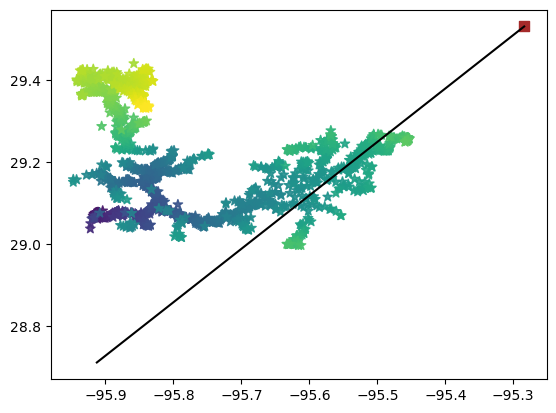

In [29]:
# Quick look at RHI relative to the selected lightning before coordinate transformations
flash_time = np.sort(one_flash.event_time)
loc_lma = plt.scatter(one_flash.event_longitude, one_flash.event_latitude, marker = '*', s = 50, c = (flash_time - flash_time[0]), cmap = 'viridis',alpha=0.9)
loc_radar = plt.scatter(radar.longitude['data'],radar.latitude['data'], color = 'brown', marker = 's', s = 60)
loc_rhi = plt.plot([radar.longitude['data'], radar.gate_longitude['data'][0][-1]],[radar.latitude['data'], radar.gate_latitude['data'][0][-1]], color = 'black')

In [30]:
# -- Initialize coordinate systems
ctrlat, ctrlon, ctralt = radar.latitude['data'][0], radar.longitude['data'][0], radar.altitude['data'][0]
geo = GeographicSystem()
tps = TangentPlaneCartesianSystem(ctrlat, ctrlon, ctralt)
rcs = RadarCoordinateSystem(ctrlat, ctrlon, ctralt)

# --- Orthogonal projection/ Matrix Rotation of the LF sources
Xlma,Ylma,Zlma = geo_to_tps(one_flash, radar)   # Filter does not have altitude
XYZlma = np.column_stack((Xlma, Ylma, Zlma))
lma_file_ortho = rot_mat_lma(radar, XYZlma, -1)  # -1 for counterclockwise

# 1st STEP
# -- Find and store sources within a certain ds distance
ds = 1000 # m threshold
r_cls, z_cls, y_min = close_sources(r_c, z_c, lma_file_ortho, ds)
# -- Selected LMA sources inside the radar scan
lma_shp = MultiPoint(tuple(np.vstack((r_cls, z_cls)).transpose()))
R_cls = [] 
Z_cls = []
Y_min = []
for i in np.arange(len(r_cls)):
    if scan_poly.contains(lma_shp[i]) == True:
        R_cls.append(np.asarray(lma_shp[i].coords[0])[0])
        Z_cls.append(np.asarray(lma_shp[i].coords[0])[1])
        Y_min.append(y_min[i])
R_cls = np.asarray(R_cls)
Z_cls = np.asarray(Z_cls)
Y_min = np.asarray(Y_min)

y-dist = [-759.43056164 -627.38030533  560.54630156 -738.77873384   18.75912959
  148.18751066 -941.83567555  682.49345725  212.74409252 -903.75048089
 -351.95626828 -182.36937528 -187.66393787 -949.84417556 -723.52741754
  101.57091691 -325.18309146  139.10470926 -698.82587574 -462.80203668
 -170.16294331  526.16686814  575.353709    732.44440332  965.24150988
  572.92640166  866.17657295  652.16787867  515.88349931  324.57381818
  254.07751247 -193.52352402 -443.20351146 -571.27869443 -455.40394804
  577.20615285 -879.13351997 -569.65494083  396.41626087 -632.83349084
 -635.89341839  553.8061951   424.04055868 -549.07840259 -769.48971708
  859.19939446 -744.6292158   953.07947144  925.83777408 -618.05228278
 -937.91195445  918.75682071 -967.35139495 -993.23820992 -807.88224927
 -826.76440002 -803.8230053  -812.12750873 -493.29362549  646.35535293
 -411.6909872   782.32141553  983.4012376  -774.24392531  968.89835538
 -676.35295781 -490.05520274  891.7885553   861.07682149  718.045798

In [31]:
# ASSUME Y = 0 - real interception
int_point1 = [np.array([R_cls[i], 0 , Z_cls[i]]) for i in np.arange(R_cls.size)]

# 2o STEP
# Transform from Rotationed Coordinate system Tangent Plane to Tangent Plan (rotates clockwise = 1)
int_point2 = rot_mat_lma(radar, int_point1, 1)

# 3o STEP
# Tangent Plan to ECEF
int_point3 = [tps.fromLocal(int_point2[i,:][:,None]) for i in np.arange(R_cls.size)]

# 4o STEP
# Transform from ECEF to Radar Coordinate System
int_point4 = [rcs.fromECEF(int_point3[i][0],int_point3[i][1],int_point3[i][2]) for i in np.arange(R_cls.size)]

# 5o STEP
# Find closest point to RHI - Elevation and Range
cls_r_idx = [closest_pt_radarloc(radar, int_point4[i])[0]  for i in np.arange(R_cls.size)]    # Radius index
cls_az_idx = [closest_pt_radarloc(radar, int_point4[i])[1]  for i in np.arange(R_cls.size)]   # Azimuth index
cls_elev_idx = [closest_pt_radarloc(radar, int_point4[i])[2]  for i in np.arange(R_cls.size)] # Elevation index

In [32]:
# -- For plots below
# -- Selecting coordinates and values for images below
sel = [int(radar.sweep_start_ray_index['data'][0]), int(radar.sweep_end_ray_index['data'][0])]
values = np.ma.getdata(radar.fields['reflectivity']['data'][sel[0] : sel[1]+1, :])
values[np.where(values < -10)] = 'nan'
re = r_e[sel[0]: sel[1]+2]
ze = z_e[sel[0]: sel[1]+2]

Text(0.09, 0.5, 'Distance above radar (km)')

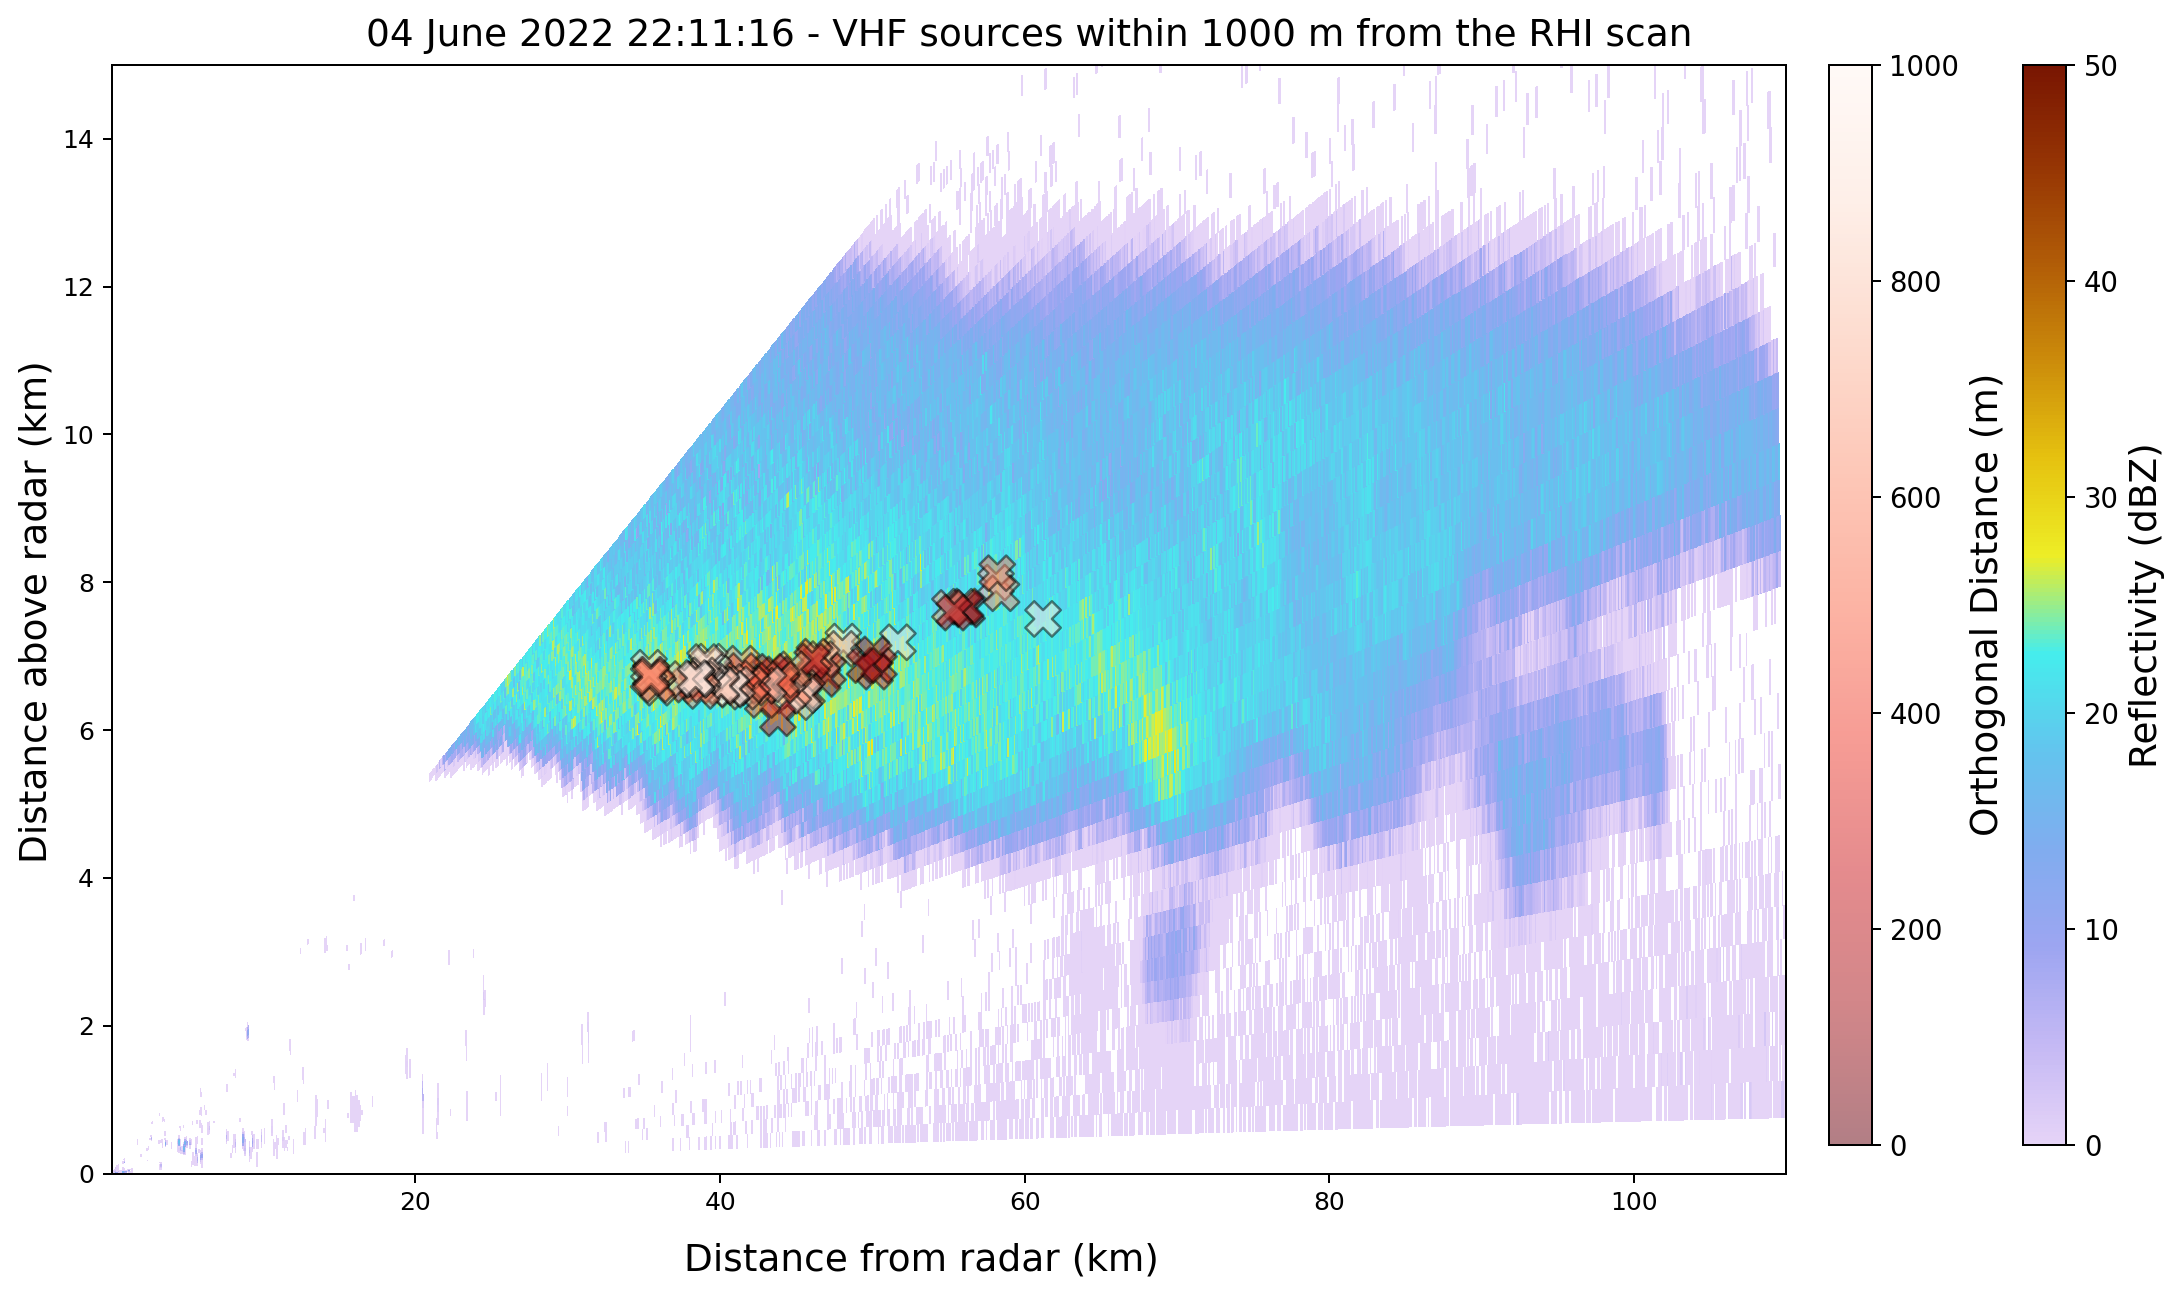

In [33]:
fig = plt.figure(figsize=(12, 8), dpi=180)
ax1 = fig.add_subplot(111)
cs = ax1.pcolormesh(re/1000, ze/1000, values, vmin = 0, vmax = 50, cmap = pcm.LangRainbow12)
llma = plt.scatter(R_cls/1000,  Z_cls/1000, c = abs(Y_min), 
                   edgecolor = 'black', cmap = 'Reds_r', marker = "X", 
                   s = 200, alpha = 0.5, vmin = 0, vmax = ds)
# plt.xlim(0,120)
plt.ylim(0,15)

# -- cbar
cb_ax = fig.add_axes([1.01, 0.13, 0.02, 0.75])
cbar = fig.colorbar(cs, cax=cb_ax)
cbar.set_label('Reflectivity (dBZ)', size=15)
cbar.ax.tick_params(labelsize=11)

llma_ax = fig.add_axes([0.92, 0.13, 0.02, 0.75])
cbar2 = fig.colorbar(llma, cax=llma_ax)
cbar2.set_label('Orthogonal Distance (m)', size=15)
cbar2.ax.tick_params(labelsize=11)

fig.text(0.55, 0.9,radar_time.strftime("%d %B %Y %H:%M:%S") + 
         f' - VHF sources within {ds} m from the RHI scan', 
         va='center', ha='center', fontsize = 15)
fig.text(0.5, 0.05, 'Distance from radar (km)', va='center', ha='center', fontsize = 15)
fig.text(0.09, 0.5, 'Distance above radar (km)', va='center', ha='center', rotation='vertical', fontsize = 15)
